<a href="https://colab.research.google.com/github/omar-sharif03/CONSTRAINT-AAAI2021/blob/main/Code/Constraint_AAAI2021_(English_Fake_News).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%time
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import re
import nltk
import json
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from keras import models
from keras import layers
from tensorflow.keras.layers import LSTM,GRU
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score
from sklearn.metrics import average_precision_score,roc_auc_score, roc_curve, precision_recall_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
np.random.seed(42)
class color: # Text style
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords

from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
CPU times: user 1.9 s, sys: 220 ms, total: 2.12 s
Wall time: 2.98 s


In [ ]:
print(tf.__version__)
print(keras.__version__)

2.3.0
2.4.0


##Data Fetching

In [ ]:
%%time
train_filename = "/content/drive/My Drive/SharedTasksParticipation/SharedTask@Constraint@AAAI2021/Constraint_English_Train.xlsx"
val_filename = "/content/drive/My Drive/SharedTasksParticipation/SharedTask@Constraint@AAAI2021/Constraint_English_Val.xlsx"

train_data = pd.read_excel(train_filename)
validation_data = pd.read_excel(val_filename)

CPU times: user 339 ms, sys: 11.9 ms, total: 351 ms
Wall time: 8.38 s


In [ ]:
print("Size of the training data ==> ", train_data.shape)
print("Size of the validation data ==>", validation_data.shape)

Size of the training data ==>  (6420, 3)
Size of the validation data ==> (2140, 3)


In [ ]:
## Mapping the labels real=0, fake=1
train_data['training_label']= train_data.label.replace({'real':0,'fake':1})
print(train_data.head(10))

   id                                              tweet label  training_label
0   1  The CDC currently reports 99031 deaths. In gen...  real               0
1   2  States reported 1121 deaths a small rise from ...  real               0
2   3  Politically Correct Woman (Almost) Uses Pandem...  fake               1
3   4  #IndiaFightsCorona: We have 1524 #COVID testin...  real               0
4   5  Populous states can generate large case counts...  real               0
5   6  Covid Act Now found "on average each person in...  real               0
6   7  If you tested positive for #COVID19 and have n...  real               0
7   8  Obama Calls Trump’s Coronavirus Response A Cha...  fake               1
8   9  ???Clearly, the Obama administration did not l...  fake               1
9  10  Retraction—Hydroxychloroquine or chloroquine w...  fake               1


In [ ]:
validation_data['validation_label']= validation_data.label.replace({'real':0,'fake':1})
validation_data.head(10)

,id,tweet,label,validation_label
0,1,Chinese converting to Islam after realising th...,fake,1
1,2,11 out of 13 people (from the Diamond Princess...,fake,1
2,3,"COVID-19 Is Caused By A Bacterium, Not Virus A...",fake,1
3,4,Mike Pence in RNC speech praises Donald Trump’...,fake,1
4,5,6/10 Sky's @EdConwaySky explains the latest #C...,real,0
5,6,No one can leave managed isolation for any rea...,real,0
6,7,#IndiaFightsCorona India has one of the lowest...,real,0
7,8,RT @WHO: #COVID19 transmission occurs primaril...,real,0
8,9,News and media outlet ABP Majha on the basis o...,fake,1
9,10,???Church services can???t resume until we???r...,fake,1


In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


#Data Cleaning

In [ ]:
%%time
## Cleaning the data. Removing newlines, unnecessary symbols

punctuations = '''’'!()-[]{};:'"\,<>./?@#$%^&*_~�'''



def remove_punctuation_url(d):
    d=d.lower()
    d = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', d, flags=re.MULTILINE) #This line is for removing url
    review = d.replace('\n', '')
    no_punct = ""
    for char in review:
      if char not in punctuations:
         no_punct = no_punct + char
    return no_punct

def remove_stopwords(d):
  text_tokens = word_tokenize(d.lower())
  tokens_without_sw = [word for word in text_tokens if not word in stopwords.words('english')]
  ls = ""
  for w in tokens_without_sw:
    ls = ls +" "+w.lower()
  return ls

#removing URLs and Punctuations
#train_data['cleaned'] = train_data['tweet'].apply(remove_url)
#Removing punctuations
train_data['cleaned'] = train_data['tweet'].apply(remove_punctuation_url)
validation_data['cleaned'] = validation_data['tweet'].apply(remove_punctuation_url)
#Removing stop words
#train_data['cleaned'] = train_data['cleaned'].apply(remove_stopwords)

## Data samples after cleaning
print("Data samples after cleaning:\n")
for i in range(10):
  print(train_data.cleaned[i])

Data samples after cleaning:

the cdc currently reports 99031 deaths in general the discrepancies in death counts between different sources are small and explicable the death toll stands at roughly 100000 people today
states reported 1121 deaths a small rise from last tuesday southern states reported 640 of those deaths 
politically correct woman almost uses pandemic as excuse not to reuse plastic bag  coronavirus nashville
indiafightscorona we have 1524 covid testing laboratories in india and as on 25th august 2020 36827520 tests have been done  profbhargava dg icmrdelhi staysafe indiawillwin 
populous states can generate large case counts but if you look at the new cases per million today 9 smaller states are showing more cases per million than california or texas al ar id ks ky la ms nv and sc 
covid act now found on average each person in illinois with covid19 is infecting 111 other people data shows that the infection growth rate has declined over time this factors in the stayatho

In [ ]:
train_data.head(10)
# Now we have raw text, label and cleaned data

,id,tweet,label,training_label,cleaned
0,1,The CDC currently reports 99031 deaths. In gen...,real,0,the cdc currently reports 99031 deaths in gene...
1,2,States reported 1121 deaths a small rise from ...,real,0,states reported 1121 deaths a small rise from ...
2,3,Politically Correct Woman (Almost) Uses Pandem...,fake,1,politically correct woman almost uses pandemic...
3,4,#IndiaFightsCorona: We have 1524 #COVID testin...,real,0,indiafightscorona we have 1524 covid testing l...
4,5,Populous states can generate large case counts...,real,0,populous states can generate large case counts...
5,6,"Covid Act Now found ""on average each person in...",real,0,covid act now found on average each person in ...
6,7,If you tested positive for #COVID19 and have n...,real,0,if you tested positive for covid19 and have no...
7,8,Obama Calls Trump’s Coronavirus Response A Cha...,fake,1,obama calls trumps coronavirus response a chao...
8,9,"???Clearly, the Obama administration did not l...",fake,1,clearly the obama administration did not leave...
9,10,Retraction—Hydroxychloroquine or chloroquine w...,fake,1,retraction—hydroxychloroquine or chloroquine w...


#Data Statistics

In [ ]:
def data_statistics(class_names):
  words_per_class = []
  unique_words_per_class = []
  documents_per_class = []

  for label in class_names:
    ## Word list from the clean dataset
    word_list = [word.strip().lower() for t in list(train_data[train_data.label==label].cleaned) for word in t.strip().split()]
    counts = dict()
    for w in word_list:
      counts[w] = counts.get(w, 0)+1
    # Sort the word list on descending order in terms of frequency
    ordered = sorted(counts.items(), key= lambda item: item[1],reverse = True)
    # Total words per class
    words_per_class.append(len(word_list))
    # Unique words per class
    unique_words_per_class.append(len(np.unique(word_list)))
    # Number of documents per class
    documents_per_class.append(len(list(train_data[train_data.label==label].cleaned)))

    print("Class name: {}".format(label))
    print("Number of words: {}".format(len(word_list)))
    print("Number of unique words: {}".format(len(np.unique(word_list)))) 
    print("Number of Documents: {}".format(len(list(train_data[train_data.label==label].cleaned))))  
    print("10 most frequent words:\n")
    for i, f in ordered[:10]:
      print("{}\t{}".format(i, f))
    
  return words_per_class, unique_words_per_class, documents_per_class

class_names = ['real','fake']

words, unique_words, documents = data_statistics(class_names)

Class name: real
Number of words: 103123
Number of unique words: 10771
Number of Documents: 3360
10 most frequent words:

the	4053
of	3071
to	2485
in	2440
covid19	2079
and	1689
cases	1564
a	1420
is	1267
are	1138
Class name: fake
Number of words: 65076
Number of unique words: 10305
Number of Documents: 3060
10 most frequent words:

the	2900
a	1664
to	1630
of	1538
in	1436
coronavirus	1294
covid19	1169
and	1038
is	781
for	716


In [ ]:
data_matrix = pd.DataFrame({'Total Documents':documents,
                            'Total Words':words,
                            'Unique Words':unique_words,
                            'Class Names':class_names})
data_matrix

,Total Documents,Total Words,Unique Words,Class Names
0,3360,103123,10771,real
1,3060,65076,10305,fake


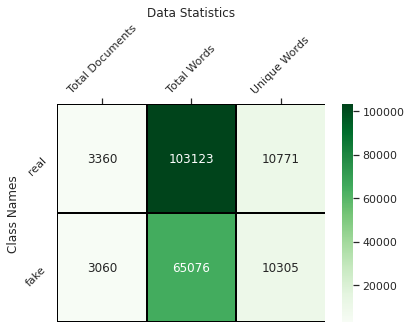

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()
plt.figure(figsize =(6, 4))
ax = plt.subplot()
sns.heatmap(data_matrix.iloc[:,0:3], annot=True,fmt="d", linewidths=0.5,linecolor = 'Black',cmap = 'Greens',ax = ax) #annot=True to annotate cells
# labels, title and ticks
ax.set_ylabel('Class Names') 
ax.set_title('Data Statistics')
y_label = ["Total Documents", "Total Words", "Unique Words"] 
ax.xaxis.set_ticklabels(y_label, rotation=45); ax.yaxis.set_ticklabels(class_names, rotation=45);
ax.xaxis.tick_top()

In [ ]:
df = pd.melt(data_matrix, id_vars="Class Names", var_name="Category", value_name="Values")
print(df)

  Class Names         Category  Values
0        real  Total Documents    3360
1        fake  Total Documents    3060
2        real      Total Words  103123
3        fake      Total Words   65076
4        real     Unique Words   10771
5        fake     Unique Words   10305


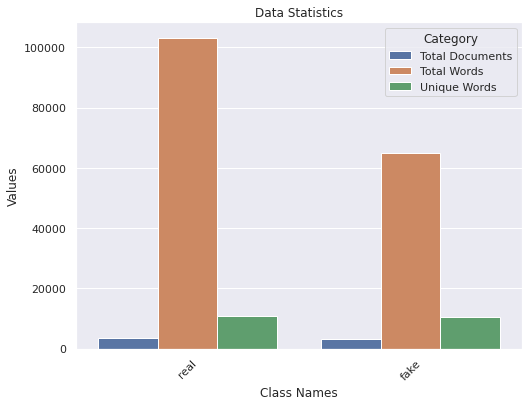

In [ ]:
plt.figure(figsize=(8, 6))
ax = plt.subplot()

sns.barplot(data=df,x='Class Names', y='Values' ,hue='Category')
ax.set_xlabel('Class Names') 
ax.set_title('Data Statistics')

ax.xaxis.set_ticklabels(class_names, rotation=45);

In [ ]:
frequency = dict()
for x in train_data['cleaned']:
  i = len(x.split())
  frequency[i] = frequency.get(i, 0)+1
frequency = sorted(frequency.items(), key= lambda item: item[0])
print(frequency)
print(type(frequency))

[(2, 1), (3, 8), (4, 10), (5, 29), (6, 62), (7, 107), (8, 115), (9, 147), (10, 171), (11, 210), (12, 224), (13, 208), (14, 233), (15, 230), (16, 192), (17, 175), (18, 176), (19, 151), (20, 167), (21, 173), (22, 153), (23, 130), (24, 160), (25, 133), (26, 118), (27, 146), (28, 129), (29, 150), (30, 152), (31, 138), (32, 137), (33, 148), (34, 133), (35, 151), (36, 123), (37, 151), (38, 155), (39, 139), (40, 124), (41, 147), (42, 115), (43, 105), (44, 105), (45, 89), (46, 86), (47, 58), (48, 56), (49, 43), (50, 37), (51, 29), (52, 12), (53, 14), (54, 10), (55, 5), (56, 4), (57, 7), (58, 4), (59, 4), (60, 2), (61, 2), (63, 1), (64, 2), (65, 2), (66, 1), (67, 2), (70, 1), (71, 1), (72, 1), (73, 1), (77, 1), (78, 1), (79, 1), (81, 1), (85, 1), (86, 1), (87, 1), (93, 2), (96, 1), (98, 1), (118, 1), (325, 1), (822, 1), (1409, 1)]
<class 'list'>


[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 63, 64, 65, 66, 67, 70, 71, 72, 73, 77, 78, 79, 81, 85, 86, 87, 93, 96, 98, 118, 325, 822, 1409] [1, 8, 10, 29, 62, 107, 115, 147, 171, 210, 224, 208, 233, 230, 192, 175, 176, 151, 167, 173, 153, 130, 160, 133, 118, 146, 129, 150, 152, 138, 137, 148, 133, 151, 123, 151, 155, 139, 124, 147, 115, 105, 105, 89, 86, 58, 56, 43, 37, 29, 12, 14, 10, 5, 4, 7, 4, 4, 2, 2, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1]


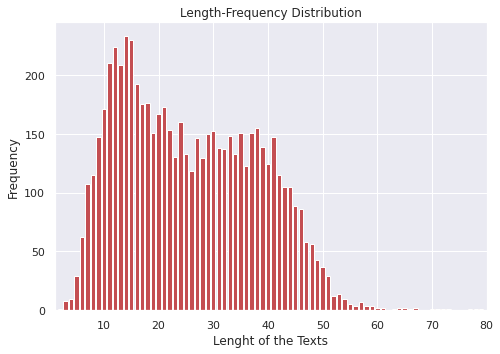

In [ ]:
xx = [x for x, k in frequency]
yy = [k for x, k in frequency]
print(xx, yy)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.bar(xx,yy, color='r')
plt.xlim(1, 80)

plt.xlabel('Lenght of the Texts')
plt.ylabel('Frequency')
plt.title('Length-Frequency Distribution')
plt.show()


#Tokenizer Definition

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

def text_encoding(texts, labels, max_words, padding_length):
  tokenizer = Tokenizer(num_words = max_words, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n-', 
                      split=' ', char_level=False, oov_token=None, document_count=0)
  
  # Tokenizer is fitted into the texts
  tokenizer.fit_on_texts(texts)

  # Printing tokenizer information
  (word_counts,word_docs,word_index,document_count) = (tokenizer.word_counts,
                                                       tokenizer.word_docs,
                                                       tokenizer.word_index,
                                                       tokenizer.document_count)
  
  def tokenizer_info(mylist):
    ordered = sorted(mylist.items(), key= lambda item: item[1],reverse = True)
    for w,c in ordered[:10]:
      print(w,"\t",c)
  
  print(color.BOLD+"\t\t\t====== Tokenizer Info ======"+color.END)   
  print("Words --> Counts:")
  tokenizer_info(word_counts)
  print("\nWords --> Documents:")
  tokenizer_info(word_docs)
  print("\nWords --> Index:")
  tokenizer_info(word_index)    
  print("\nTotal Documents -->",document_count)

  # Encoding texts into integer sequences
  sequences = tokenizer.texts_to_sequences(texts)
  word_index = tokenizer.word_index
  print(color.BOLD+"\n\t\t\t====== Encoded Sequences ======"+color.END,"\nFound {} unique tokens".format(len(word_index)))  
  print(texts[10],"\n",sequences[10])

  # Pad sequences
  corpus = keras.preprocessing.sequence.pad_sequences(sequences, value=0.0,
                                                      padding='post', maxlen= padding_length)
  print("\n\t\t\t====== Paded Sequences ======\n",texts[10],"\n",corpus[10])

  return corpus, labels, tokenizer

##
max_words = 20000# Based on number of unique words in the dataset
padding_length = 100

corpus, labels, tokenizer = text_encoding(train_data.cleaned, train_data.training_label, max_words, padding_length)   



			====== Tokenizer Info ======
Words --> Counts:
the 	 6953
of 	 4609
to 	 4115
in 	 3876
covid19 	 3248
a 	 3084
and 	 2727
is 	 2048
for 	 1831
cases 	 1721

Words --> Documents:
the 	 3733
of 	 3061
to 	 2859
in 	 2695
covid19 	 2684
a 	 2193
and 	 2068
is 	 1612
for 	 1537
coronavirus 	 1496

Words --> Index:
infertility 	 17523
dargah 	 17522
intubate 	 17521
repandybiggsaz 	 17520
rickleventhal 	 17519
ashley 	 17518
charliekirk11 	 17517
daveman19802 	 17516
kagashley 	 17515
reserved 	 17514

Total Documents --> 6420

			====== Encoded Sequences ====== 
Found 17523 unique tokens
take simple daily precautions to help prevent the spread of respiratory illnesses like covid19 learn how to protect yourself from coronavirus covid19   
 [163, 1269, 92, 1461, 3, 141, 237, 1, 98, 2, 695, 1082, 177, 5, 173, 152, 3, 217, 360, 15, 11, 5]

			====== Paded Sequences ======
 take simple daily precautions to help prevent the spread of respiratory illnesses like covid19 learn how to protect yo

In [ ]:
training_data, training_labels = corpus, labels

In [ ]:
print(training_data, training_labels)

[[   1  140  271 ...    0    0    0]
 [  35   41 7571 ...    0    0    0]
 [5152 1842  437 ...    0    0    0]
 ...
 [   6  326  161 ...    0    0    0]
 [2930 1014 2802 ...    0    0    0]
 [  33   19   32 ...    0    0    0]] 0       0
1       0
2       1
3       0
4       0
       ..
6415    1
6416    1
6417    1
6418    1
6419    0
Name: training_label, Length: 6420, dtype: int64


#Define Callbacks()

In [ ]:
## Defining Callbacks
def define_callback():
  keras.backend.clear_session()
  accuracy_threshold = .999

  class myCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>accuracy_threshold):
          print("\nReached %2.2f%% accuracy so we will stop trianing" % (accuracy_threshold*100))
          self.model.stop_training = True

  acc_callback = myCallback()

  return acc_callback

# Define TensorBoard
def define_TensorBoard():
  %load_ext tensorboard
  import datetime, os
  logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

  return tensorboard_callback

# Define Checkpoint
def define_checkpoint():
  filepath = "ModelOnOurData.h5"
  checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=2, save_best_only=True, save_weights_only=False, mode='max')
  return checkpoint

#Model Definition

In [ ]:
# Create Model
def create_model(embedding_dim):
  keras.backend.clear_session()
  no_of_class = len(class_names)

  model = keras.models.Sequential([
      keras.layers.Embedding(max_words, embedding_dim, input_length = padding_length),
      #keras.layers.Conv1D(64, 5, activation='relu'),
      #keras.layers.MaxPooling1D(5),
      #keras.layers.Bidirectional(LSTM(64, return_sequences=True, dropout=0.2)),
      keras.layers.Bidirectional(LSTM(32, dropout=0.2)),
      keras.layers.Flatten(),
      keras.layers.Dense(no_of_class, activation = 'softmax')
  ])

  model.summary()
  return model

# Visualize Model
def model_visualize(model):
  from tensorflow.keras.utils import plot_model
  plot_model(model, to_file = 'print.png', show_shapes = True, show_layer_names = True)

# Compile Model
def compile_model(model):
  model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics='accuracy')
  return model


In [ ]:
%%time
## Callbacks are really important 

def run_callback_list():
  acc_callback = define_callback()
  checkpoint = define_checkpoint()
  tensorboard_callback = define_TensorBoard()
  return [acc_callback, checkpoint, tensorboard_callback] 

callback_list = run_callback_list()

def run_model():
    embedding_dim = 100
    model = create_model(embedding_dim)
    model = compile_model(model)
    model_visualize(model)
    return model

## Create, Compile and Visualize the model
cnn_lstm_model = run_model() ## 


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          2000000   
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                34048     
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 2)                 130       
Total params: 2,034,178
Trainable params: 2,034,178
Non-trainable params: 0
_________________________________________________________________
CPU times: user 531 ms, sys: 59.6 ms, total: 591 ms
Wall time: 660 ms


In [ ]:
cnn_lstm_model_history = cnn_lstm_model.fit(training_data,
                              training_labels,
                              epochs = 100,
                              batch_size = 128,
                              verbose = 1,
                              validation_split = 0.15,
                              callbacks = callback_list)

Epoch 1/100
42/43 [============================>.] - ETA: 0s - loss: 0.5695 - accuracy: 0.7167
Epoch 00001: val_accuracy improved from -inf to 0.86397, saving model to ModelOnOurData.h5
43/43 [==============================] - 2s 57ms/step - loss: 0.5681 - accuracy: 0.7176 - val_loss: 0.3536 - val_accuracy: 0.8640
Epoch 2/100
43/43 [==============================] - ETA: 0s - loss: 0.2571 - accuracy: 0.8998
Epoch 00002: val_accuracy improved from 0.86397 to 0.91381, saving model to ModelOnOurData.h5
43/43 [==============================] - 2s 39ms/step - loss: 0.2571 - accuracy: 0.8998 - val_loss: 0.2328 - val_accuracy: 0.9138
Epoch 3/100
43/43 [==============================] - ETA: 0s - loss: 0.1155 - accuracy: 0.9624
Epoch 00003: val_accuracy did not improve from 0.91381
43/43 [==============================] - 2s 39ms/step - loss: 0.1155 - accuracy: 0.9624 - val_loss: 0.2288 - val_accuracy: 0.9065
Epoch 4/100
43/43 [==============================] - ETA: 0s - loss: 0.0534 - accurac

# Prediction on validation Set

In [ ]:
val_filename = "/content/drive/My Drive/SharedTasksParticipation/SharedTask@Constraint@AAAI2021/Constraint_English_Val.xlsx"
validation_data = pd.read_excel(val_filename)
print("\n\nSize of the validation data ==> ", len(validation_data))
print(validation_data.head(5))

print(type(validation_data))
print(validation_data.head(10))

validation_data['validation_label']= validation_data.label.replace({'real':0,'fake':1}) 

## Cleaning the data. Removing newlines, unnecessary symbols
#validation_data['cleaned'] = validation_data['tweet'].apply(remove_url)
validation_data['cleaned'] = validation_data['tweet'].apply(remove_punctuation_url)
#data['cleaned'] = data['cleaned'].apply(remove_stopwords)
print(validation_data.head(10))



Size of the validation data ==>  2140
   id                                              tweet label
0   1  Chinese converting to Islam after realising th...  fake
1   2  11 out of 13 people (from the Diamond Princess...  fake
2   3  COVID-19 Is Caused By A Bacterium, Not Virus A...  fake
3   4  Mike Pence in RNC speech praises Donald Trump’...  fake
4   5  6/10 Sky's @EdConwaySky explains the latest #C...  real
<class 'pandas.core.frame.DataFrame'>
   id                                              tweet label
0   1  Chinese converting to Islam after realising th...  fake
1   2  11 out of 13 people (from the Diamond Princess...  fake
2   3  COVID-19 Is Caused By A Bacterium, Not Virus A...  fake
3   4  Mike Pence in RNC speech praises Donald Trump’...  fake
4   5  6/10 Sky's @EdConwaySky explains the latest #C...  real
5   6  No one can leave managed isolation for any rea...  real
6   7  #IndiaFightsCorona India has one of the lowest...  real
7   8  RT @WHO: #COVID19 transmission oc

In [ ]:
## Converting into interger index based on tokenizer word index. It is important for predicting
val_sequences = tokenizer.texts_to_sequences(validation_data.cleaned)
print(val_sequences[0:10])
val_data = keras.preprocessing.sequence.pad_sequences(val_sequences, value=0.0,
                                                      padding='post', maxlen= padding_length)
val_labels = validation_data['validation_label']

print(val_data[:5], val_data.shape)
print(val_labels[:5], val_labels.shape)

[[311, 11378, 3, 4650, 93, 13, 56, 921, 46, 555, 28, 11, 10993, 4, 1, 139], [501, 102, 2, 661, 24, 15, 1, 5493, 4274, 1749, 1409, 38, 119, 83, 302, 4, 26, 4, 1346, 58, 1189, 39, 3, 27, 84, 4, 1, 411, 35], [5, 8, 453, 28, 6, 2638, 30, 69, 7, 43, 27, 916, 18, 5446], [2309, 2331, 4, 8910, 4368, 13122, 254, 755, 5, 6520, 2258, 18, 973, 7, 2568, 102, 1, 2214, 57, 3856], [3838, 1122, 1, 165, 5, 79, 7, 131, 2752, 128, 25, 14, 1, 11, 79], [56, 63, 43, 1579, 194, 123, 9, 185, 1015, 427, 912, 6, 302, 87, 62, 61, 2031, 6, 87, 61, 43, 424, 27, 1867, 9, 6, 706, 2, 68, 3, 582, 86, 200, 200, 14, 370, 1, 4053, 5377, 14, 2577, 4632, 17, 32, 6227, 200, 200], [64, 52, 19, 63, 2, 1, 524, 5, 645, 1544, 18, 353, 47, 88, 72, 520, 101, 20, 6, 559, 2, 6669, 136, 123, 45, 405, 443, 262, 179, 516, 17, 1764, 499, 47, 1, 215, 191], [81, 38, 5, 372, 12572, 4779, 261, 2528, 53, 322, 224, 18, 174, 24, 261, 77, 6914, 7], [120, 7, 343, 6705, 14, 1, 1249, 2, 54, 9847, 2, 333, 1087, 3044, 41, 13, 6, 1646, 2162, 19, 32, 3

In [ ]:
val_ls, val_acc = cnn_lstm_model.evaluate(val_data, val_labels)
print(val_ls, val_acc)

## To find class wise probability
predicted_probability = cnn_lstm_model.predict(val_data)
print(predicted_probability)

# Find the predicted class for every input text
predicted_classess = np.argmax(cnn_lstm_model.predict(val_data), axis=-1)
print(predicted_classess)

67/67 [==============================] - 0s 7ms/step - loss: 0.3181 - accuracy: 0.9145
0.318080335855484 0.9144859910011292
[[4.4000056e-04 9.9955994e-01]
 [9.9616832e-01 3.8316993e-03]
 [1.8231604e-03 9.9817681e-01]
 ...
 [7.0005126e-04 9.9929988e-01]
 [7.6376176e-01 2.3623820e-01]
 [9.9878973e-01 1.2103065e-03]]
[1 0 1 ... 1 0 0]


In [ ]:
predictions = np.argmax(cnn_lstm_model.predict(val_data), axis = -1)
cm = confusion_matrix(val_labels, predictions)
acc = round(accuracy_score(val_labels, predictions),4)*100 
prec = round(precision_score(val_labels, predictions, average='weighted'),4)*100
re = round(recall_score(val_labels, predictions, average='weighted'),4)*100
f1 = round(f1_score(val_labels, predictions, average= 'weighted'),4)*100
print(color.BOLD+'Confusion Matrix:\n'+color.END,cm)
print (color.BOLD+'Report : '+color.END)
print (classification_report(val_labels, predictions) )
print(color.BOLD+'Performance:\n'+color.END)
pd.DataFrame({'Accuracy':acc,'Precision':prec,'Recall':re,'F1 Score':f1},index = ['CNN+BiLSTM'])

Confusion Matrix:
 [[1019  101]
 [  82  938]]
Report : 
              precision    recall  f1-score   support

           0       0.93      0.91      0.92      1120
           1       0.90      0.92      0.91      1020

    accuracy                           0.91      2140
   macro avg       0.91      0.91      0.91      2140
weighted avg       0.91      0.91      0.91      2140

Performance:



,Accuracy,Precision,Recall,F1 Score
CNN+BiLSTM,91.45,91.47,91.45,91.45


In [ ]:
# Find out some misclassified text. Check which class overlaps with other classes
for i in range(50):
  actual = val_labels[i]
  prediction = predicted_classess[i]
  if(actual!=prediction):
      print("Actual Data: {}\nPredicted Label: {}\nActual Label: {}\n".format(validation_data['tweet'][i], class_names[prediction], class_names[actual]))

Actual Data: 11 out of 13 people (from the Diamond Princess Cruise ship) who had intially tested negative in tests in Japan were later confirmed to be positive in the United States.
Predicted Label: real
Actual Label: fake

Actual Data: You can still fly the friendly skies without fear of COVID if airlines stay serious about safety. https://t.co/H8mGjwDl7G #coronavirus
Predicted Label: fake
Actual Label: real

Actual Data: Gov. Andrew Cuomo “was simply saying if we can share 20 percent of your excess your non-used ventilators to help people in other parts of the state on a voluntary basis that would be great. Of course there was a reaction to that which was not positive."
Predicted Label: real
Actual Label: fake

Actual Data: Breathlessness excessive fatigue and muscle aches from COVID can last for months. https://t.co/OUhBRirKpE
Predicted Label: fake
Actual Label: real

Actual Data: EMA endorses the use of dexamethasone for COVID-19. https://t.co/RKPH74Hz3W
Predicted Label: fake
Actua

[[1023   97]
 [  88  932]]


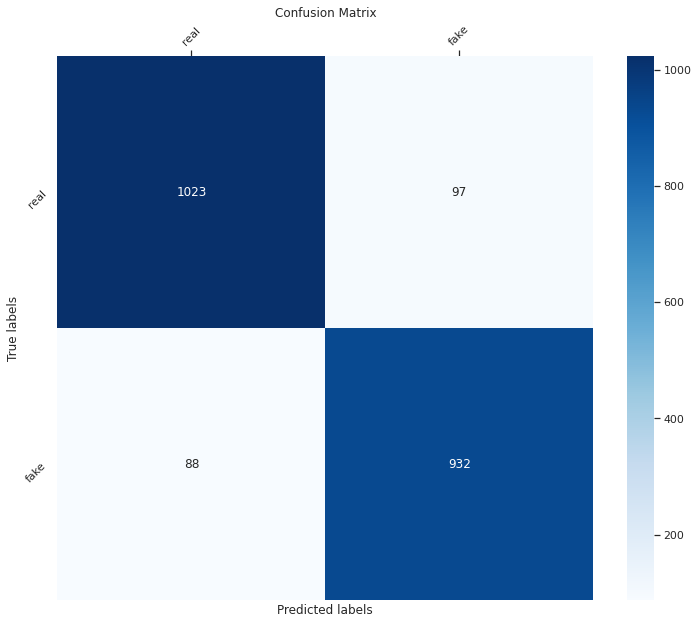

In [ ]:
def con_mat(model):
  test_prediction = np.argmax(model.predict(val_data), axis = -1)
  cm = confusion_matrix(val_labels, test_prediction)
  print(cm)

  import seaborn as sns
  #sns.set()
  plt.figure(figsize =(12, 10))
  ax = plt.subplot()
  sns.heatmap(cm, annot=True,fmt="d",cmap='Blues', ax = ax) #annot=True to annotate cells
  # labels, title and ticks
  ax.set_xlabel('Predicted labels')
  ax.set_ylabel('True labels') 
  ax.set_title('Confusion Matrix') 
  ax.xaxis.set_ticklabels(class_names, rotation=45); ax.yaxis.set_ticklabels(class_names, rotation=45);
  ax.xaxis.tick_top()

con_mat(cnn_lstm_model)

In [ ]:
with open('answer.txt', 'w') as f:
  f.write("id,label\n")
  for i in range(len(predicted_classess)):
    id = data['id'][i]
    v = class_names[predicted_classess[i]]
    f.write("%d,%s\n"%(id, v))

#ML Methods

In [ ]:
tf_idf = TfidfVectorizer(ngram_range=(1,3), min_df=5, tokenizer=lambda x: x.split(), max_features=20000, use_idf = True)
corpus = tf_idf.fit_transform(train_data.cleaned)
labels = train_data.training_label
print(corpus.shape)

(6420, 9448)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(corpus,labels,train_size = 0.9, test_size = 0.1,random_state =0)
print(X_train.shape, X_test.shape)

(5778, 9448) (642, 9448)


In [ ]:
%%time 
                  #=================================
                  #########  Define models  #########
                  #==================================
lr_model = LogisticRegression(random_state = 123,C =0.08)
dt_model = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
rf_model = RandomForestClassifier(n_estimators=10, criterion ='entropy', random_state = 0)
mnb_model = MultinomialNB(alpha=0.05)
model_names = ['Logistic Regression','Decision Tree','Random Forest','Naive Bayes']
ml_models = [lr_model,dt_model,rf_model,mnb_model]

               #============================================
               ####### Model Fit Function ############
               #=============================================
def model_train(model, X_train, y_train):
    model.fit(X_train,y_train)
    return model

trained_ml_models = []
for i in ml_models:
    tt = model_train(i,X_train, y_train)
    trained_ml_models.append(tt)

CPU times: user 1.33 s, sys: 582 µs, total: 1.33 s
Wall time: 1.34 s


In [ ]:
               #============================================
               ####### Model Evaluation Function ############
              #=============================================

acc_list = []
pr_list = []
re_list = []
f1_list = []

def model_accuracy(model,X_test,y_test, model_name):
  print("Classifier: ", model_name)
  pred_y = model.predict(X_test)
  print(color.BOLD+'Confusion Matrix:\n'+color.END,confusion_matrix(y_test, pred_y))
  print (color.BOLD+'Report : '+color.END)
  print (classification_report(y_test, pred_y))
  acc_list.append((round(accuracy_score(y_test, pred_y),4)*100))
  pr_list.append((round(precision_score(y_test, pred_y, average='weighted'),4)*100)) 
  re_list.append((round(recall_score(y_test, pred_y, average='weighted'),4)*100))
  f1_list.append((round(f1_score(y_test, pred_y, average='weighted'),4)*100))

for i in range(len(trained_ml_models)):
    md = trained_ml_models[i]
    name = model_names[i]
    model_accuracy(md, X_test, y_test, name)


Classifier:  Logistic Regression
Confusion Matrix:
 [[288  41]
 [ 49 264]]
Report : 
              precision    recall  f1-score   support

           0       0.85      0.88      0.86       329
           1       0.87      0.84      0.85       313

    accuracy                           0.86       642
   macro avg       0.86      0.86      0.86       642
weighted avg       0.86      0.86      0.86       642

Classifier:  Decision Tree
Confusion Matrix:
 [[267  62]
 [ 53 260]]
Report : 
              precision    recall  f1-score   support

           0       0.83      0.81      0.82       329
           1       0.81      0.83      0.82       313

    accuracy                           0.82       642
   macro avg       0.82      0.82      0.82       642
weighted avg       0.82      0.82      0.82       642

Classifier:  Random Forest
Confusion Matrix:
 [[275  54]
 [ 44 269]]
Report : 
              precision    recall  f1-score   support

           0       0.86      0.84      0.85     

In [ ]:
performance_matrix = pd.DataFrame({'Accuracy':acc_list,'Precision':pr_list,
                                   'Recall':re_list,'F1 Score':f1_list},
                                  index =model_names)
performance_matrix

,Accuracy,Precision,Recall,F1 Score
Logistic Regression,85.98,85.99,85.98,85.97
Decision Tree,82.09,82.12,82.09,82.09
Random Forest,84.74,84.78,84.74,84.74
Naive Bayes,88.63,88.85,88.63,88.62
